In [2]:
#Import libraries
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

In [4]:
# Load the dataset
# Load datasets
customers_data = pd.read_csv("Customers.csv")
transactions_data = pd.read_csv("Transactions.csv")
products_data = pd.read_csv("Products.csv")

In [6]:
# Step 1: Aggregate transaction data
customer_transactions = transactions_data.groupby("CustomerID").agg(
    TotalSpent=("TotalValue", "sum"),
    AvgTransactionValue=("TotalValue", "mean"),
    TransactionFrequency=("TransactionID", "count")
).reset_index()

In [8]:
# Step 2: Extract favorite product categories
customer_products = transactions_data.merge(products_data, on="ProductID", how="left")
favorite_category = customer_products.groupby(["CustomerID", "Category"]).size().reset_index(name="Count")
favorite_category = favorite_category.loc[favorite_category.groupby("CustomerID")["Count"].idxmax()]
favorite_category = favorite_category[["CustomerID", "Category"]]

In [10]:
# Step 3: Combine features
customer_features = customers_data.merge(customer_transactions, on="CustomerID", how="left")
customer_features = customer_features.merge(favorite_category, on="CustomerID", how="left")

In [14]:
# Step 4: Feature preprocessing
numerical_features = ["TotalSpent", "AvgTransactionValue", "TransactionFrequency"]
categorical_features = ["Region", "Category"]

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ]
)

X = preprocessor.fit_transform(customer_features)

In [24]:
X

array([[-0.06170143, -0.07026341, -0.01145819, ...,  1.        ,
         0.        ,  0.        ],
       [-0.87774353, -0.93493297, -0.46749414, ...,  0.        ,
         0.        ,  0.        ],
       [-0.40585722, -0.02627131, -0.46749414, ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [-1.38697529, -0.93396389, -1.37956603, ...,  0.        ,
         0.        ,  0.        ],
       [-0.81399315, -0.81217559, -0.46749414, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.70636652,  1.11292648, -0.01145819, ...,  0.        ,
         0.        ,  0.        ]])

In [26]:
# Step 1: Identify missing values
print("Number of NaNs in data:", np.isnan(X).sum())

# Step 2: Handle missing values
# Replaces NaN with 0
X = np.nan_to_num(X)  


Number of NaNs in data: 3


In [28]:
# Step 5: Compute similarity
similarity_matrix = cosine_similarity(X)

In [32]:
# Step 6: Generate lookalikes
lookalike_map = {}
customer_ids = customer_features["CustomerID"].tolist()

for i, cust_id in enumerate(customer_ids):
    similarity_scores = list(enumerate(similarity_matrix[i]))
    similarity_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)
    top_lookalikes = [(customer_ids[j], round(score, 2)) for j, score in similarity_scores[1:4]]
    lookalike_map[cust_id] = top_lookalikes

In [34]:
# Step 7: Save results for first 20 customers
lookalike_results = {cust_id: lookalike_map[cust_id] for cust_id in customer_ids[:20]}

lookalike_df = pd.DataFrame({
    "cust_id": list(lookalike_results.keys()),
    "lookalikes": [str(lookalike_results[cust_id]) for cust_id in lookalike_results.keys()]
})

lookalike_df.to_csv("Lookalike.csv", index=False)
print("Lookalike.csv has been generated!")

Lookalike.csv has been generated!


In [36]:
lookalike = pd.read_csv("Lookalike.csv")

In [44]:
lookalike

,cust_id,lookalikes
0,C0001,"[('C0190', 0.97), ('C0048', 0.94), ('C0181', 0..."
1,C0002,"[('C0088', 0.97), ('C0134', 0.94), ('C0106', 0..."
2,C0003,"[('C0052', 0.98), ('C0152', 0.93), ('C0031', 0..."
3,C0004,"[('C0165', 0.97), ('C0155', 0.96), ('C0169', 0..."
4,C0005,"[('C0186', 0.98), ('C0146', 0.96), ('C0007', 0..."
5,C0006,"[('C0168', 0.97), ('C0171', 0.95), ('C0187', 0..."
6,C0007,"[('C0140', 0.98), ('C0115', 0.93), ('C0005', 0..."
7,C0008,"[('C0109', 0.87), ('C0139', 0.81), ('C0098', 0..."
8,C0009,"[('C0010', 0.98), ('C0198', 0.95), ('C0062', 0..."
9,C0010,"[('C0009', 0.98), ('C0111', 0.97), ('C0103', 0..."


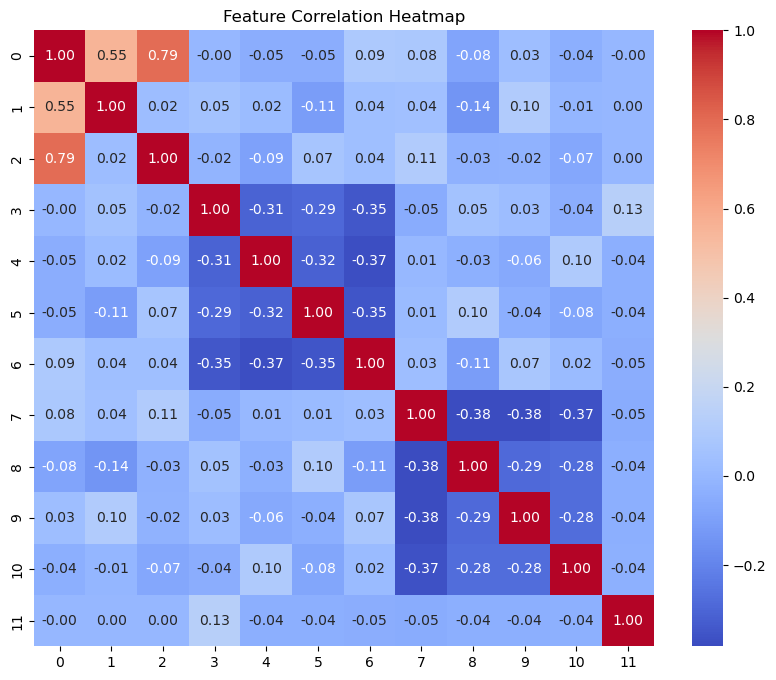

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

# Correlation matrix for features
import pandas as pd

X_df = pd.DataFrame(X)  # Assuming X is the feature matrix
plt.figure(figsize=(10, 8))
sns.heatmap(X_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()


In [42]:
# Print top-3 similarities for a sample customer
sample_customer_index = 0
top_indices = similarity_matrix[sample_customer_index].argsort()[-4:-1][::-1]  # Exclude self-match
print(f"Top-3 similar customers to Customer {sample_customer_index}:")
for idx in top_indices:
    print(f"Customer {idx} with similarity score: {similarity_matrix[sample_customer_index, idx]:.4f}")


Top-3 similar customers to Customer 0:
Customer 189 with similarity score: 0.9682
Customer 47 with similarity score: 0.9411
Customer 180 with similarity score: 0.9090


In [46]:
# Diversity metric: Calculate variance across similarity scores for recommendations
def calculate_diversity(similarities):
    return similarities.var()

# Example for first 20 customers
diversity_scores = []
for i in range(20):
    top_scores = similarity_matrix[i].argsort()[-4:-1]  # Top-3 recommendations
    diversity = calculate_diversity(similarity_matrix[i, top_scores])
    diversity_scores.append(diversity)

print("Diversity scores for the first 20 customers:", diversity_scores)


Diversity scores for the first 20 customers: [0.0005848335732169587, 0.0008135437109064854, 0.0014998278347426695, 0.001410054777064952, 0.0009862214579713317, 0.00014850132594536252, 0.0008649119940596482, 0.0011568104070832155, 0.00034170027137213284, 7.783588937384873e-05, 0.0003942552369019645, 0.0005868973777998206, 0.0036044427164136548, 0.0011014227220459622, 0.004481504293123045, 0.010588448949717754, 0.003137004120962057, 0.0030262803727862304, 0.0024898721139321126, 0.0014105349156142064]


In [48]:
def precision_at_k(true_labels, predicted_labels, k=3):
    """
    true_labels: Set of true similar customers
    predicted_labels: Top-k predicted similar customers
    k: Number of recommendations to evaluate
    """
    relevant_count = sum([1 for pred in predicted_labels if pred in true_labels])
    return relevant_count / k

# Example:
true_similar_customers = {1, 5, 7}  # For a given customer
predicted_similar_customers = [5, 8, 7]  # Model's top-3 recommendations
precision = precision_at_k(true_similar_customers, predicted_similar_customers)
print(f"Precision@3: {precision:.2f}")


Precision@3: 0.67
